In [1]:
# Function to filter data into different flow types
def filter_data(df):
    outbound = df[(df['Origin Region'] == 32003) & (df['Destination Region'] != 32003)]
    inbound = df[(df['Origin Region'] != 32003) & (df['Destination Region'] == 32003)]
    through = df[(df['Origin Region'] != 32003) & (df['Destination Region'] != 32003)]
    intra = df[(df['Origin Region'] == 32003) & (df['Destination Region'] == 32003)]
    return outbound, inbound, through, intra

# Function to summarize flow by region, state, and country
def summarize_flow_by_region(df, flow_type, region_column, state_column, country_column):
    group_by_columns = ['Year', region_column, state_column, country_column]
    summary = df.groupby(group_by_columns).agg({
        'Value': 'sum',
        'Tons': 'sum'
    }).reset_index()
    summary.rename(columns={region_column: 'Region Name', state_column: 'State', country_column: 'Country'}, inplace=True)
    summary.columns = summary.columns.tolist()[:-2] + [f'{flow_type} Value', f'{flow_type} Tons']
    return summary

# Function to summarize flow by state and country
def summarize_flow_by_state_and_country(df, flow_type, state_column, country_column):
    group_by_columns = ['Year', state_column, country_column]
    summary = df.groupby(group_by_columns).agg({
        'Value': 'sum',
        'Tons': 'sum'
    }).reset_index()
    summary.rename(columns={state_column: 'State', country_column: 'Country'}, inplace=True)
    summary.columns = summary.columns.tolist()[:-2] + [f'{flow_type} Value', f'{flow_type} Tons']
    return summary

# Function to summarize flow by country
def summarize_flow_by_country(df, flow_type, country_column):
    group_by_columns = ['Year', country_column]
    summary = df.groupby(group_by_columns).agg({
        'Value': 'sum',
        'Tons': 'sum'
    }).reset_index()
    summary.rename(columns={country_column: 'Country'}, inplace=True)
    summary.columns = summary.columns.tolist()[:-2] + [f'{flow_type} Value', f'{flow_type} Tons']
    return summary



# Load data:
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

# Load data:
clark_county_ts2021 = pd.read_csv("H:/My Drive/7. SNV Industry Study/SNV_ArcGIS/IHS Files/Clark_County_TS2021.csv")
bridges_excel = pd.ExcelFile("H:/My Drive/7. SNV Industry Study/SNV_ArcGIS/IHS Files/bridges.xlsx")

# Load necessary sheets from the Excel file
stcc = bridges_excel.parse("STCC")
modes = bridges_excel.parse("Modes")
regions = bridges_excel.parse("Regions")

# Define origin_regions and destination_regions separately
origin_regions = regions.rename(columns={"Region": "Origin Region", "Region Name": "Origin Region Name"})
destination_regions = regions.rename(columns={"Region": "Destination Region", "Region Name": "Destination Region Name"})


# Ensure 'STCC4' column in both dataframes is of type string
# For example, replace NaN with a known string
stcc['STCC4'] = stcc['STCC4'].astype(str)
# naics_stcc['STCC4'] = naics_stcc['STCC4'].astype(str)
# naics_stcc['NAICS_code'] = naics_stcc['NAICS_code'].astype(str)
# Create a new DataFrame from 'stcc' that only includes rows with 2-digit 'STCC' codes
stcc_2digit = stcc[stcc['STCC'].str.len() == 2].copy()
# Ensure 'STCC4' is of type string
stcc_2digit['STCC4'] = stcc_2digit['STCC4'].astype(str)
# Merge stcc_2digit and naics_stcc using STCC4
#stcc_2digit = pd.merge(stcc_2digit, naics_stcc, how='left', on='STCC4')
#stcc = pd.merge(stcc, naics_stcc, how='left', on='STCC4')

# Merge stcc (which now includes naics_stcc data) into clark_county_ts2021 using STCC
clark_county_ts2021 = pd.merge(clark_county_ts2021, stcc, how='left', on='STCC')

# Merge modes into clark_county_ts2021 using Mode
clark_county_ts2021 = pd.merge(clark_county_ts2021, modes, how='left', on='Mode')
# Merge origin_regions and destination_regions into clark_county_ts2021
clark_county_ts2021 = pd.merge(clark_county_ts2021, origin_regions, on='Origin Region', how='left')
clark_county_ts2021 = pd.merge(clark_county_ts2021, destination_regions, on='Destination Region', how='left')

# Create 'STCC_2digit' column in 'clark_county_ts2021' DataFrame
clark_county_ts2021['STCC_2digit'] = clark_county_ts2021['STCC'].str[:2]

# Print DataFrame to check
#print(clark_county_ts2021)
# Rename the rest of the columns
clark_county_ts2021.rename(columns={
    'State_x': 'Origin State', 
    'BEA_x': 'Origin BEA', 
    'BEA Name_x': 'Origin BEA Name', 
    'Country_x': 'Origin Country', 
    'State_y': 'Destination State', 
    'BEA_y': 'Destination BEA', 
    'BEA Name_y': 'Destination BEA Name', 
    'Country_y': 'Destination Country'}, inplace=True)



In [2]:
# Apply filters to DataFrame
outbound, inbound, through, intra = filter_data(clark_county_ts2021)

# Summarize by Region:
outbound_summary_R = summarize_flow_by_region(outbound, 'OB', 'Destination Region Name', 'Destination State', 'Destination Country')
inbound_summary_R = summarize_flow_by_region(inbound, 'IB', 'Origin Region Name', 'Origin State', 'Origin Country')
through_origin_summary_R = summarize_flow_by_region(through, 'Thr Origin', 'Origin Region Name', 'Origin State', 'Origin Country')
through_destination_summary_R = summarize_flow_by_region(through, 'Thr Destination', 'Destination Region Name', 'Destination State', 'Destination Country')
intra_summary_R = summarize_flow_by_region(intra, 'Intr', 'Origin Region Name', 'Origin State', 'Origin Country')


# Summarize by State and Country:
outbound_summary_ST = summarize_flow_by_state_and_country(outbound, 'OB', 'Destination State', 'Destination Country')
inbound_summary_ST = summarize_flow_by_state_and_country(inbound, 'IB', 'Origin State', 'Origin Country')
through_origin_summary_ST = summarize_flow_by_state_and_country(through, 'Thr Origin', 'Origin State', 'Origin Country')
through_destination_summary_ST = summarize_flow_by_state_and_country(through, 'Thr Destination', 'Destination State', 'Destination Country')
intra_summary_ST = summarize_flow_by_state_and_country(intra, 'Intr', 'Origin State', 'Origin Country')
# ...

# Summarize by Country:
outbound_summary_C = summarize_flow_by_country(outbound, 'OB', 'Destination Country')
inbound_summary_C = summarize_flow_by_country(inbound, 'IB', 'Origin Country')
through_origin_summary_C = summarize_flow_by_country(through, 'Thr Origin', 'Origin Country')
through_destination_summary_C = summarize_flow_by_country(through, 'Thr Destination', 'Destination Country')
intra_summary_C = summarize_flow_by_country(intra, 'Intr', 'Origin Country')
# ...

# Print totals:
total_sum = through_origin_summary_C['Thr Origin Value'].sum()
print(f"The total sum of the through_origin_summary_C 'Thr Origin Value' is {total_sum}")
# ...


The total sum of the through_origin_summary_C 'Thr Origin Value' is 552841471775.4816


In [3]:
final_summary_R = outbound_summary_R.merge(inbound_summary_R, on=['Year', 'Region Name', 'State', 'Country'], how='outer')
final_summary_R = final_summary_R.merge(through_origin_summary_R, on=['Year', 'Region Name', 'State', 'Country'], how='outer')
final_summary_R = final_summary_R.merge(through_destination_summary_R, on=['Year', 'Region Name', 'State', 'Country'], how='outer')
final_summary_R = final_summary_R.merge(intra_summary_R, on=['Year', 'Region Name', 'State', 'Country'], how='outer')

In [4]:
final_summary_R

,Year,Region Name,State,Country,OB Value,OB Tons,IB Value,IB Tons,Thr Origin Value,Thr Origin Tons,Thr Destination Value,Thr Destination Tons,Intr Value,Intr Tons
0,2015,"Aberdeen, SD BEA",SD,US,3.796326e+05,124.626548,4.798905e+06,2072.707395,1.510608e+08,89527.914399,3.742401e+07,13768.420233,NaN,NaN
1,2015,"Abilene, TX BEA",TX,US,1.071864e+06,1233.699262,1.765090e+07,12756.702552,3.909632e+06,4067.429843,1.216421e+07,186259.195407,NaN,NaN
2,2015,"Adams County, ND",ND,US,3.843786e+02,5.237087,1.854684e+04,119.184828,1.025102e+06,6316.376702,2.559429e+05,92.196517,NaN,NaN
3,2015,Aguascalientes,AG,MX,1.825927e+05,40.342971,1.152363e+06,133.478185,3.508684e+04,9.018925,1.070827e+05,75.362247,NaN,NaN
4,2015,Alabama Portion of Atlanta BEA,AL,US,4.654752e+04,17.804393,1.891225e+06,415.830234,NaN,NaN,3.024976e+03,43.326627,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,2050,Guerrero,GR,MX,NaN,NaN,NaN,NaN,NaN,NaN,3.729551e+04,179.318340,NaN,NaN
1492,2015,"Clark County, NV",NV,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.165316e+09,1.610371e+07
1493,2019,"Clark County, NV",NV,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.045947e+09,1.633485e+07
1494,2021,"Clark County, NV",NV,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.073076e+09,1.606648e+07


In [5]:
print(final_summary_R.columns)

Index(['Year', 'Region Name', 'State', 'Country', 'OB Value', 'OB Tons',
       'IB Value', 'IB Tons', 'Thr Origin Value', 'Thr Origin Tons',
       'Thr Destination Value', 'Thr Destination Tons', 'Intr Value',
       'Intr Tons'],
      dtype='object')


In [6]:
clark_county_ts2021

,Year,Origin Region,Destination Region,STCC,Trade Type,Mode,Tons,Units,Value,Average Miles,...,Origin State,Origin BEA,Origin BEA Name,Origin Country,Destination Region Name,Destination State,Destination BEA,Destination BEA Name,Destination Country,STCC_2digit
0,2015,1,165,01 14,D,4,0.060575,0.003927,1.678699e+01,2348.3999,...,AL,36,"Dothan, AL",US,Nevada Portion of Reno BEA,NV,151,"Reno, NV",US,01
1,2015,1,165,01 19,D,4,0.447512,0.021637,6.846934e+01,2348.3999,...,AL,36,"Dothan, AL",US,Nevada Portion of Reno BEA,NV,151,"Reno, NV",US,01
2,2015,1,165,14 51,D,4,0.295351,0.012149,1.261019e+01,2339.9998,...,AL,36,"Dothan, AL",US,Nevada Portion of Reno BEA,NV,151,"Reno, NV",US,14
3,2015,1,166,35 35,D,5,3.790659,0.285492,3.219333e+04,2192.8999,...,AL,36,"Dothan, AL",US,Remainder of Nevada Portion of Las Vegas BEA,NV,153,"Las Vegas, NV",US,35
4,2015,1,32003,01 19,D,4,0.735466,0.035559,1.125264e+02,1970.6001,...,AL,36,"Dothan, AL",US,"Clark County, NV",NV,153,"Las Vegas, NV",US,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058238,2050,32003,32003,50 1,D,5,36925.441000,1796.137100,5.283480e+07,16.0000,...,NV,153,"Las Vegas, NV",US,"Clark County, NV",NV,153,"Las Vegas, NV",US,50
1058239,2050,32003,32003,50 1,D,6,841962.750000,40954.977000,1.204723e+09,16.0000,...,NV,153,"Las Vegas, NV",US,"Clark County, NV",NV,153,"Las Vegas, NV",US,50
1058240,2050,32003,32003,50 22,D,4,196761.920000,13588.907000,1.063695e+09,16.0000,...,NV,153,"Las Vegas, NV",US,"Clark County, NV",NV,153,"Las Vegas, NV",US,50
1058241,2050,32003,32003,50 31,D,4,62400.527000,3167.539600,8.104652e+08,16.0000,...,NV,153,"Las Vegas, NV",US,"Clark County, NV",NV,153,"Las Vegas, NV",US,50


In [8]:
print(clark_county_ts2021.columns)

Index(['Year', 'Origin Region', 'Destination Region', 'STCC', 'Trade Type',
       'Mode', 'Tons', 'Units', 'Value', 'Average Miles', 'First Node',
       'Last Node', 'From FIPS', 'To FIPS', 'Entry Road', 'Exit Road',
       'Commodity', 'STCC4', 'Code', 'Name', 'Group', 'Origin Region Name',
       'Origin State', 'Origin BEA', 'Origin BEA Name', 'Origin Country',
       'Destination Region Name', 'Destination State', 'Destination BEA',
       'Destination BEA Name', 'Destination Country', 'STCC_2digit'],
      dtype='object')


In [7]:
through_origin_summary_R

,Year,Region Name,State,Country,Thr Origin Value,Thr Origin Tons
0,2015,"Aberdeen, SD BEA",SD,US,1.510608e+08,8.952791e+04
1,2015,"Abilene, TX BEA",TX,US,3.909632e+06,4.067430e+03
2,2015,"Adams County, ND",ND,US,1.025102e+06,6.316377e+03
3,2015,Aguascalientes,AG,MX,3.508684e+04,9.018925e+00
4,2015,Alabama Portion of Columbus BEA,AL,US,2.092286e+05,2.299999e+02
...,...,...,...,...,...,...
1235,2050,Wisconsin Portion of Madison BEA,WI,US,2.083883e+09,7.405164e+05
1236,2050,Wisconsin Portion of Minneapolis BEA,WI,US,5.944888e+08,2.415466e+05
1237,2050,Wyoming Portion of Billings BEA,WY,US,1.453712e+08,1.700689e+05
1238,2050,Wyoming Portion of Casper BEA,WY,US,8.226121e+08,1.279076e+06


In [14]:
def summarize_flow_by_region_and_commodity(df, flow_type, region_number_column, region_column, state_column, country_column):
    group_by_columns = ['Year', region_number_column, region_column, state_column, country_column, 'STCC', 'Commodity']
    summary = df.groupby(group_by_columns).agg({
        'Value': 'sum',
        'Tons': 'sum'
    }).reset_index()
    summary.rename(columns={region_column: 'Region Name', region_number_column: 'Region', state_column: 'State', country_column: 'Country'}, inplace=True)
    summary.columns = summary.columns.tolist()[:-2] + [f'{flow_type} Value', f'{flow_type} Tons']
    return summary




def summarize_flow_by_state_and_country_and_commodity(df, flow_type, state_column, country_column):
    group_by_columns = ['Year', state_column, country_column, 'STCC', 'Commodity']
    summary = df.groupby(group_by_columns).agg({
        'Value': 'sum',
        'Tons': 'sum'
    }).reset_index()
    summary.rename(columns={state_column: 'State', country_column: 'Country'}, inplace=True)
    summary.columns = summary.columns.tolist()[:-2] + [f'{flow_type} Value', f'{flow_type} Tons']
    return summary


def summarize_flow_by_country_and_commodity(df, flow_type, country_column):
    group_by_columns = ['Year', country_column, 'STCC', 'Commodity']
    summary = df.groupby(group_by_columns).agg({
        'Value': 'sum',
        'Tons': 'sum'
    }).reset_index()
    summary.rename(columns={country_column: 'Country'}, inplace=True)
    summary.columns = summary.columns.tolist()[:-2] + [f'{flow_type} Value', f'{flow_type} Tons']
    return summary


In [15]:
outbound_summary_R_commodity = summarize_flow_by_region_and_commodity(outbound, 'OB', 'Destination Region', 'Destination Region Name', 'Destination State', 'Destination Country')
inbound_summary_R_commodity = summarize_flow_by_region_and_commodity(inbound, 'IB', 'Origin Region', 'Origin Region Name', 'Origin State', 'Origin Country')
through_origin_summary_R_commodity = summarize_flow_by_region_and_commodity(through, 'Thr Origin', 'Origin Region', 'Origin Region Name', 'Origin State', 'Origin Country')
through_destination_summary_R_commodity = summarize_flow_by_region_and_commodity(through, 'Thr Destination', 'Destination Region', 'Destination Region Name', 'Destination State', 'Destination Country')
intra_summary_R_commodity = summarize_flow_by_region_and_commodity(intra, 'Intr', 'Origin Region', 'Origin Region Name', 'Origin State', 'Origin Country')


In [16]:
final_summary_R_commodity = outbound_summary_R_commodity.merge(inbound_summary_R_commodity, on=['Year', 'Region', 'Region Name', 'State', 'Country', 'STCC', 'Commodity'], how='outer')
final_summary_R_commodity = final_summary_R_commodity.merge(through_origin_summary_R_commodity, on=['Year', 'Region', 'Region Name', 'State', 'Country', 'STCC', 'Commodity'], how='outer')
final_summary_R_commodity = final_summary_R_commodity.merge(through_destination_summary_R_commodity, on=['Year', 'Region', 'Region Name', 'State', 'Country', 'STCC', 'Commodity'], how='outer')
final_summary_R_commodity = final_summary_R_commodity.merge(intra_summary_R_commodity, on=['Year', 'Region', 'Region Name', 'State', 'Country', 'STCC', 'Commodity'], how='outer')


In [17]:
final_summary_R_commodity

,Year,Region,Region Name,State,Country,STCC,Commodity,OB Value,OB Tons,IB Value,IB Tons,Thr Origin Value,Thr Origin Tons,Thr Destination Value,Thr Destination Tons,Intr Value,Intr Tons
0,2015,1,Alabama Portion of Dothan BEA,AL,US,01 19,Misc. Field Crops,227.162490,1.484722,112.52637,0.735466,68.469345,0.447512,NaN,NaN,NaN,NaN
1,2015,1,Alabama Portion of Dothan BEA,AL,US,14 41,Gravel or Sand,9.821602,1.083613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,Alabama Portion of Dothan BEA,AL,US,14 91,"Misc Nonmetallic Minerals, Nec",182.737490,3.367619,NaN,NaN,NaN,NaN,41.947498,0.773039,NaN,NaN
3,2015,1,Alabama Portion of Dothan BEA,AL,US,20 86,Soft Drinks or Mineral Water,9750.074200,13.045655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,Alabama Portion of Dothan BEA,AL,US,20 97,"Ice, Natural or Manufactured",1979.918900,3.726000,3761.07930,7.077958,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225426,2050,32003,"Clark County, NV",NV,US,42 21,Semi-trailers Returned Empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000
225427,2050,32003,"Clark County, NV",NV,US,50 1,Warehouse & Distribution Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.467582e+09,1025670.771
225428,2050,32003,"Clark County, NV",NV,US,50 22,Rail Intermodal Drayage from Ramp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.063695e+09,196761.920
225429,2050,32003,"Clark County, NV",NV,US,50 31,Air Freight Drayage to Airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.104652e+08,62400.527


In [40]:
# Filter the final summary DataFrame to include only the specified regions
regions_of_interest = [11, 166, 270]
filtered_summary = final_summary_R_commodity[final_summary_R_commodity['Region'].isin(regions_of_interest)]

# Group by 'STCC' and 'Commodity', then sum the value and tons columns
summary_by_commodity = filtered_summary.groupby(['Year','Region', 'Region Name', 'State','STCC', 'Commodity']).agg({
    'OB Value': 'sum',
    'IB Value': 'sum',
    'Thr Origin Value': 'sum',
    'Thr Destination Value': 'sum',
    'Intr Value': 'sum',
    'OB Tons': 'sum',
    'IB Tons': 'sum',
    'Thr Origin Tons': 'sum',
    'Thr Destination Tons': 'sum',
    'Intr Tons': 'sum'
}).reset_index()

# Calculate the total value and total tons for each commodity
summary_by_commodity['Total Value'] = summary_by_commodity[['OB Value', 'IB Value', 'Thr Origin Value', 'Thr Destination Value', 'Intr Value']].sum(axis=1)
summary_by_commodity['Total Tons'] = summary_by_commodity[['OB Tons', 'IB Tons', 'Thr Origin Tons', 'Thr Destination Tons', 'Intr Tons']].sum(axis=1)

# Create empty DataFrames to store the top 5 by value and tons
top_5_by_value = pd.DataFrame()
top_5_by_tons = pd.DataFrame()

# Iterate through each region and year, and get the top 5 commodities
for region in regions_of_interest:
    for year in summary_by_commodity['Year'].unique():
        subset = summary_by_commodity[(summary_by_commodity['Region'] == region) & (summary_by_commodity['Year'] == year)]
        top_5_value = subset.nlargest(5, 'Total Value')
        top_5_tons = subset.nlargest(5, 'Total Tons')
        top_5_by_value = top_5_by_value.append(top_5_value)
        top_5_by_tons = top_5_by_tons.append(top_5_tons)

# Now, top_5_by_value and top_5_by_tons contain the top 5 commodities for each region and year


In [31]:
top_5_by_value

,Year,Region,Region Name,State,STCC,Commodity,OB Value,IB Value,Thr Origin Value,Thr Destination Value,Intr Value,OB Tons,IB Tons,Thr Origin Tons,Thr Destination Tons,Intr Tons,Total Value,Total Tons
149,2015,11,"Mohave County, AZ",AZ,29 11,Petroleum Refining Products,1.620859e+08,0.000000e+00,0.000000e+00,1.329087e+04,0.0,200561.916000,0.000000,0.000000,124.930360,0.0,1.620992e+08,200686.846360
294,2015,11,"Mohave County, AZ",AZ,40 29,Misc Waste or Scrap,1.392147e+07,2.930087e+06,2.472363e+06,8.470312e+06,0.0,48680.565600,10245.923380,8645.355107,29618.970178,0.0,2.779423e+07,97190.814265
160,2015,11,"Mohave County, AZ",AZ,30 72,Misc Plastic Products,7.222210e+05,7.969051e+06,8.255155e+06,3.874182e+06,0.0,184.555740,2036.404470,2109.515183,989.994484,0.0,2.082061e+07,5320.469877
297,2015,11,"Mohave County, AZ",AZ,50 1,Warehouse & Distribution Center,1.008445e+05,0.000000e+00,1.901727e+07,7.398012e+05,0.0,70.478684,0.000000,13290.877761,517.035818,0.0,1.985791e+07,13878.392263
299,2015,11,"Mohave County, AZ",AZ,50 32,Air Freight Drayage from Airport,8.092576e+06,5.255889e+06,0.000000e+00,0.000000e+00,0.0,623.075500,404.669130,0.000000,0.000000,0.0,1.334846e+07,1027.744630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3747,2050,270,Utah Portion of Las Vegas BEA,UT,50 22,Rail Intermodal Drayage from Ramp,2.131934e+08,0.000000e+00,0.000000e+00,7.164237e+07,0.0,39436.430000,0.000000,0.000000,13252.379000,0.0,2.848357e+08,52688.809000
3426,2050,270,Utah Portion of Las Vegas BEA,UT,20 26,Processed Milk,4.669359e+05,3.112312e+07,1.727891e+08,6.332550e+06,0.0,429.047115,28597.688700,158768.438230,5818.705534,0.0,2.107117e+08,193613.879579
3558,2050,270,Utah Portion of Las Vegas BEA,UT,29 11,Petroleum Refining Products,1.507773e+08,1.146960e+02,0.000000e+00,7.437897e+02,0.0,181526.056761,0.117437,0.000000,0.524073,0.0,1.507782e+08,181526.698271
3547,2050,270,Utah Portion of Las Vegas BEA,UT,28 31,Drugs,1.985594e+06,8.889486e+06,4.152406e+07,9.085716e+07,0.0,66.324150,296.932536,1387.014544,3062.256769,0.0,1.432563e+08,4812.527999


In [32]:
top_5_by_tons

,Year,Region,Region Name,State,STCC,Commodity,OB Value,IB Value,Thr Origin Value,Thr Destination Value,Intr Value,OB Tons,IB Tons,Thr Origin Tons,Thr Destination Tons,Intr Tons,Total Value,Total Tons
19,2015,11,"Mohave County, AZ",AZ,14 41,Gravel or Sand,8.852053e+05,1.517496e+06,3.301179e+04,1.914175e+05,0.0,96661.176000,1.674247e+05,3075.456492,21090.418280,0.0,2.627131e+06,2.882517e+05
149,2015,11,"Mohave County, AZ",AZ,29 11,Petroleum Refining Products,1.620859e+08,0.000000e+00,0.000000e+00,1.329087e+04,0.0,200561.916000,0.000000e+00,0.000000,124.930360,0.0,1.620992e+08,2.006868e+05
294,2015,11,"Mohave County, AZ",AZ,40 29,Misc Waste or Scrap,1.392147e+07,2.930087e+06,2.472363e+06,8.470312e+06,0.0,48680.565600,1.024592e+04,8645.355107,29618.970178,0.0,2.779423e+07,9.719081e+04
22,2015,11,"Mohave County, AZ",AZ,14 91,"Misc Nonmetallic Minerals, Nec",5.049000e+04,3.139889e+06,1.587413e+06,2.462746e+05,0.0,930.466500,5.786417e+04,24158.090116,4868.727271,0.0,5.024067e+06,8.782145e+04
18,2015,11,"Mohave County, AZ",AZ,14 21,Broken Stone or Riprap,1.972633e+05,1.179585e+05,2.625659e+03,1.600116e+04,0.0,16731.405200,1.000496e+04,222.702198,1357.369491,0.0,3.338486e+05,2.831644e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3406,2050,270,Utah Portion of Las Vegas BEA,UT,14 41,Gravel or Sand,2.365076e+05,1.146150e+07,4.196362e+05,1.903942e+04,0.0,25219.817000,1.264542e+06,46298.267841,1810.643813,0.0,1.213669e+07,1.337871e+06
3386,2050,270,Utah Portion of Las Vegas BEA,UT,01 19,Misc. Field Crops,0.000000e+00,4.182007e+06,3.929383e+07,9.371645e+04,0.0,0.000000,2.733338e+04,256822.445884,606.953927,0.0,4.356956e+07,2.847628e+05
3741,2050,270,Utah Portion of Las Vegas BEA,UT,40 29,Misc Waste or Scrap,1.543223e+07,1.167715e+07,2.112976e+07,3.133876e+07,0.0,53963.388600,4.083263e+04,73886.522276,105038.564765,0.0,7.957790e+07,2.737211e+05
3426,2050,270,Utah Portion of Las Vegas BEA,UT,20 26,Processed Milk,4.669359e+05,3.112312e+07,1.727891e+08,6.332550e+06,0.0,429.047115,2.859769e+04,158768.438230,5818.705534,0.0,2.107117e+08,1.936139e+05


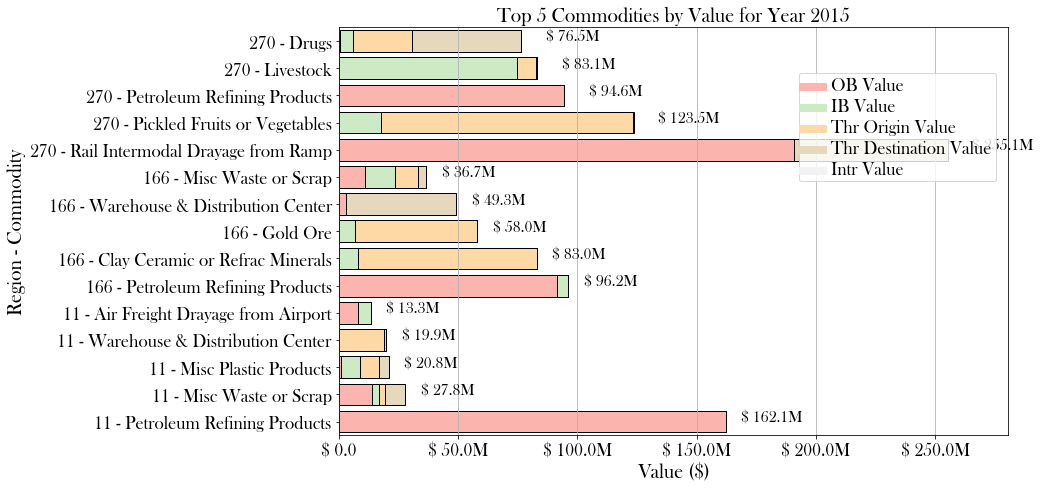

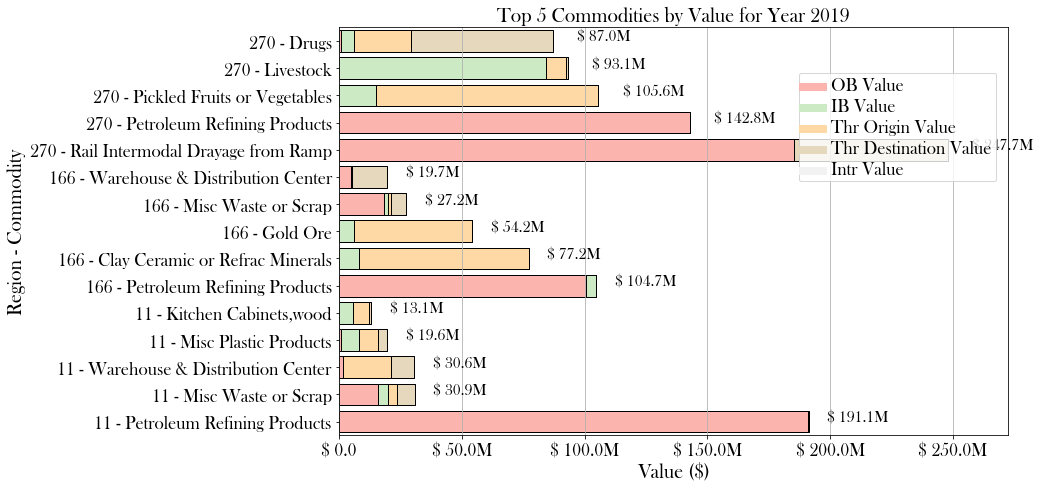

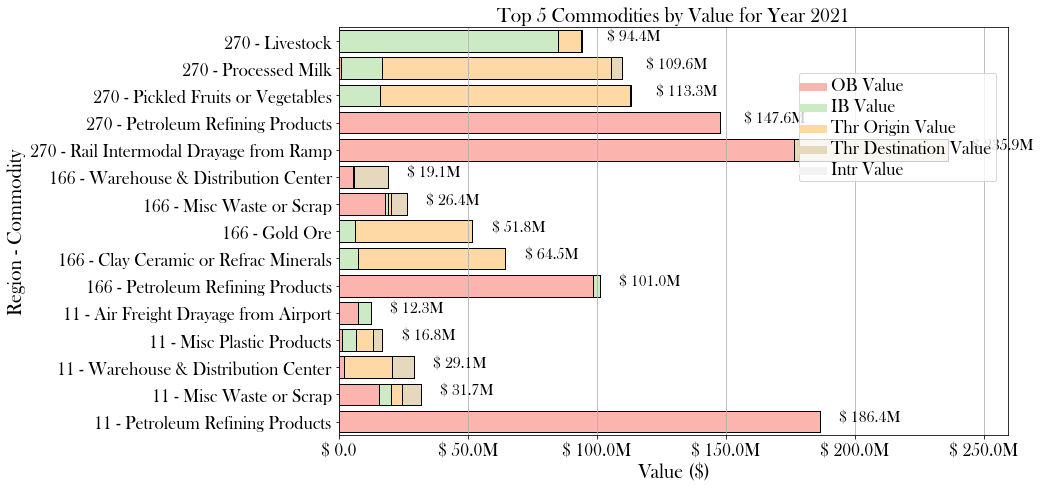

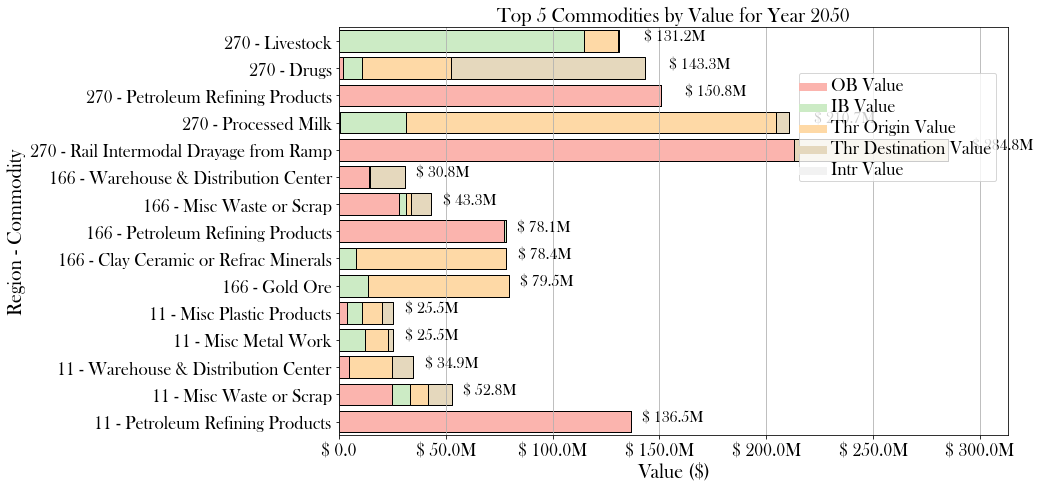

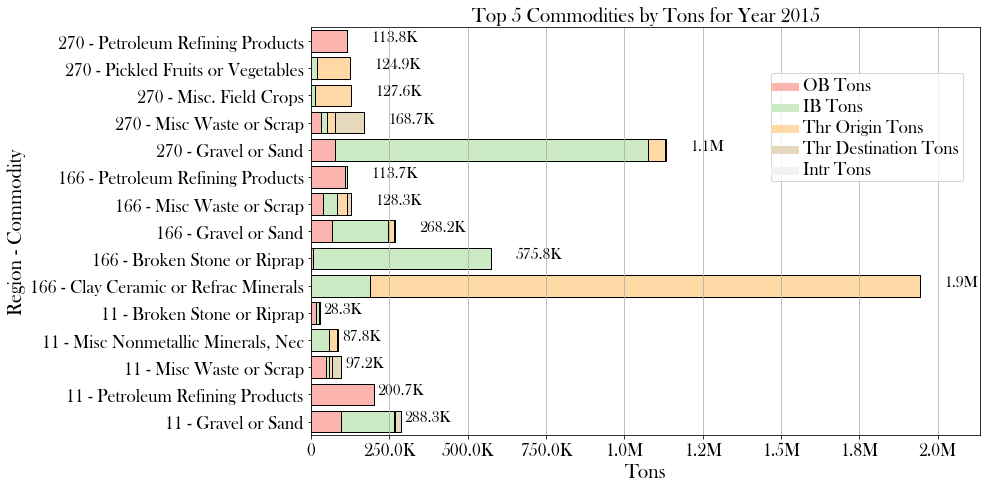

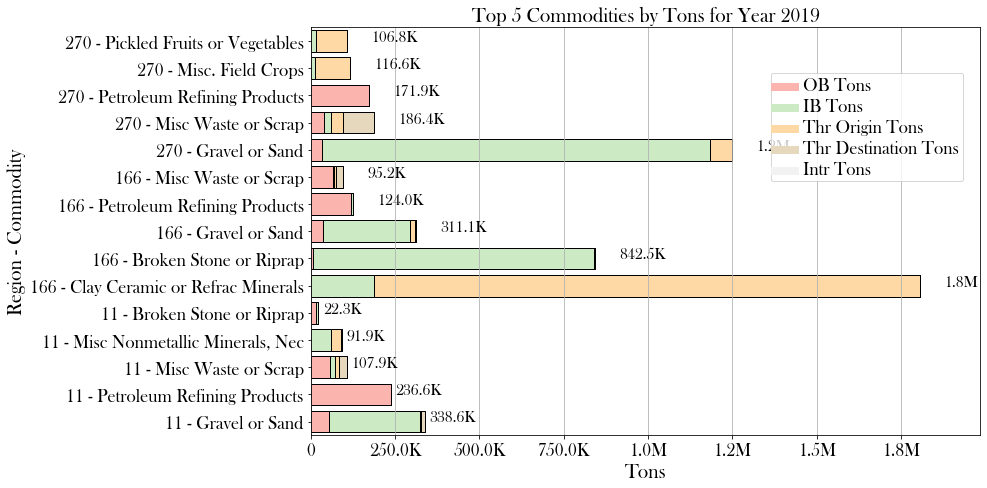

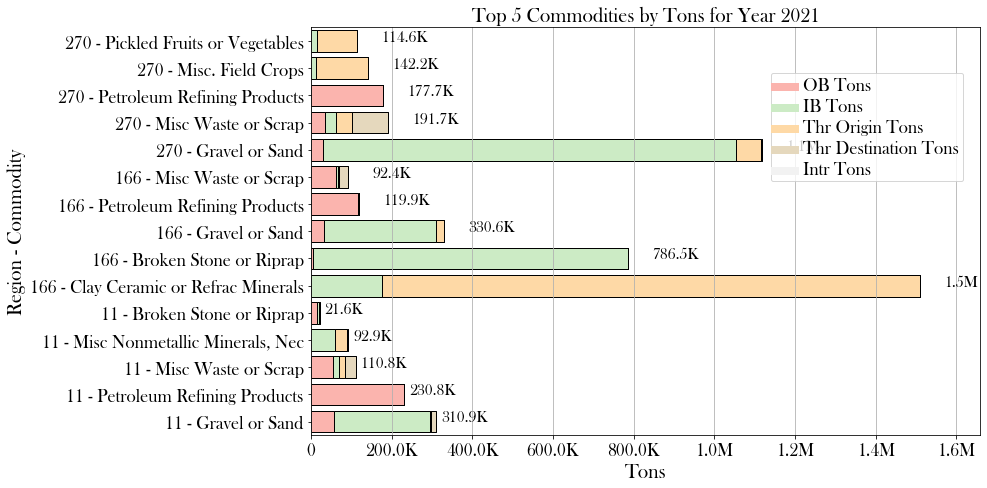

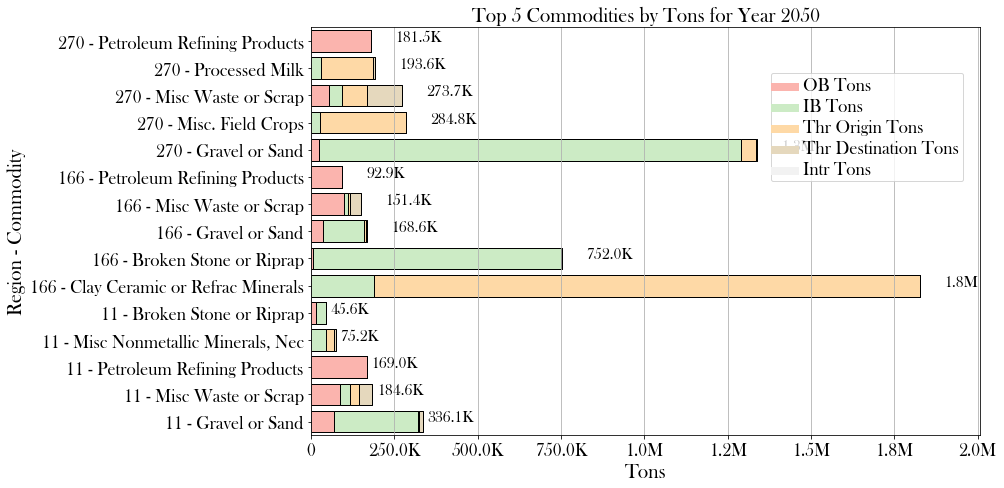

In [61]:
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

font = FontProperties(family='Baskerville Old Face')

def formatter(x, pos, data_type):
    if data_type == 'Value':
        return f'$ {x/1e9:.1f}B' if x >= 1e9 else f'$ {x/1e6:.1f}M' if x >= 1e6 else f'$ {x/1e3:.1f}K' if x >= 1e3 else f'$ {x:.1f}'
    else:
        return f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.1f}K' if x >= 1e3 else f'{x:.0f}'

def plot_top_5_by_year_and_region(df, data_type):
    directions = [f'OB {data_type}', f'IB {data_type}', f'Thr Origin {data_type}', f'Thr Destination {data_type}', f'Intr {data_type}']
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(directions)))

    for year in df['Year'].unique():
        year_data = df[df['Year'] == year].copy()
        year_data['Region_Commodity'] = year_data['Region'].astype(str) + ' - ' + year_data['Commodity']

        fig, ax = plt.subplots(figsize=(12, len(year_data) * 0.5))
        ax.set_ylim([-0.5, len(year_data) - 0.5])

        max_y_value = 0
        bar_index = 0
        for idx, row in year_data.iterrows():
            left_value = 0
            total_value = 0
            for i, direction in enumerate(directions):
                value = row[direction] if not pd.isnull(row[direction]) else 0
                rects = ax.barh(row['Region_Commodity'], value, color=colors[i], edgecolor='black', left=left_value, label=direction if year == df['Year'].unique()[0] else "", alpha=1.0, height=0.8)
                width = rects[0].get_width()
                max_y_value = max(max_y_value, left_value + width)
                left_value += value
                total_value += value

            ax.annotate(formatter(total_value, 0, data_type), xy=(total_value + (max_y_value * 0.04), bar_index), xycoords='data', fontsize=16, color='black', fontproperties=font)
            bar_index += 1

        ax.set_xlim([0, max_y_value * 1.1])

        legend_elements = [plt.Line2D([0], [0], color=colors[i], lw=8, label=direction) for i, direction in enumerate(directions)]
        legend = ax.legend(handles=legend_elements, bbox_to_anchor=(0.68, .9), loc='upper left')

        for text in legend.get_texts():
            text.set_fontproperties(font)
            text.set_fontsize(18)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties(font)
            tick.set_fontsize(18)
        for tick in ax.get_yticklabels():
            tick.set_fontproperties(font)
            tick.set_fontsize(18)

        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: formatter(x, pos, data_type)))
        ax.xaxis.grid(True, linestyle='-')
        ax.set_title(f'Top 5 Commodities by {data_type} for Year {year}', fontsize=20, fontproperties=font)
        ax.set_xlabel(data_type + (' ($)' if data_type == 'Value' else ''), fontsize=20, fontproperties=font)
        ax.set_ylabel('Region - Commodity', fontsize=20, fontproperties=font)
        plt.show()

# Usage
plot_top_5_by_year_and_region(top_5_by_value, 'Value')
plot_top_5_by_year_and_region(top_5_by_tons, 'Tons')



In [45]:
# Define the file paths
value_file_path = r'H:\My Drive\7. SNV Industry Study\1.) Summary\Regions\File\top_5_by_value.xlsx'
tons_file_path = r'H:\My Drive\7. SNV Industry Study\1.) Summary\Regions\File\top_5_by_tons.xlsx'

# Save the DataFrames to Excel files
top_5_by_value.to_excel(value_file_path, index=False)
top_5_by_tons.to_excel(tons_file_path, index=False)


In [55]:
# Group by Year, Region, and other necessary columns, then sum the directional values
summary_values = final_summary_R_commodity.groupby(['Year', 'Region', 'Region Name']).agg({
    'OB Value': 'sum',
    'IB Value': 'sum',
    'Thr Origin Value': 'sum',
    'Thr Destination Value': 'sum',
    'Intr Value': 'sum'
}).reset_index()

# Calculate the total value for each group
summary_values['Total Value'] = summary_values[['OB Value', 'IB Value', 'Thr Origin Value', 'Thr Destination Value', 'Intr Value']].sum(axis=1)

# You can then filter or manipulate this DataFrame as needed for your analysis


In [56]:
summary_values

,Year,Region,Region Name,OB Value,IB Value,Thr Origin Value,Thr Destination Value,Intr Value,Total Value
0,2015,1,Alabama Portion of Dothan BEA,1.899230e+05,9.692946e+06,3.229120e+04,15172.172018,0.000000e+00,9.930332e+06
1,2015,2,Alabama Portion of Columbus BEA,3.704673e+05,9.019400e+06,2.092286e+05,19161.118080,0.000000e+00,9.618257e+06
2,2015,3,Alabama Portion of Atlanta BEA,4.654752e+04,1.891225e+06,0.000000e+00,3024.975885,0.000000e+00,1.940797e+06
3,2015,4,Alabama Portion of Huntsville BEA,9.993680e+05,4.862281e+07,1.330959e+04,27726.212820,0.000000e+00,4.966321e+07
4,2015,5,Alabama Portion of Tupelo BEA,3.261746e+04,5.841818e+05,7.597087e+04,1121.626263,0.000000e+00,6.938918e+05
...,...,...,...,...,...,...,...,...,...
1491,2050,387,Tamaulipas,5.031492e+06,2.143074e+07,3.513810e+07,77650.813000,0.000000e+00,6.167799e+07
1492,2050,389,Veracruz,0.000000e+00,1.907922e+05,0.000000e+00,62089.977000,0.000000e+00,2.528821e+05
1493,2050,390,Yucatan,0.000000e+00,5.699608e+04,4.955055e+04,0.000000,0.000000e+00,1.065466e+05
1494,2050,391,Zacatecas,5.599034e+06,2.653762e+06,0.000000e+00,127227.840000,0.000000e+00,8.380024e+06


In [59]:
# Filter the summary_values DataFrame to include only the specified regions
regions_of_interest = [11, 166, 270]

filtered_summary_values = summary_values[summary_values['Region'].isin(regions_of_interest)]

# You can now work with the filtered_summary_values DataFrame for further analysis
filtered_summary_values

,Year,Region,Region Name,OB Value,IB Value,Thr Origin Value,Thr Destination Value,Intr Value,Total Value
10,2015,11,"Mohave County, AZ",2.065561e+08,6.142336e+07,8.016708e+07,1.200437e+08,0.0,4.681902e+08
165,2015,166,Remainder of Nevada Portion of Las Vegas BEA,1.094366e+08,4.503524e+07,1.478220e+08,7.082190e+07,0.0,3.731157e+08
269,2015,270,Utah Portion of Las Vegas BEA,3.209468e+08,1.634195e+08,5.320041e+08,6.337466e+08,0.0,1.650117e+09
384,2019,11,"Mohave County, AZ",2.455968e+08,6.193960e+07,8.001028e+07,1.489377e+08,0.0,5.364843e+08
539,2019,166,Remainder of Nevada Portion of Las Vegas BEA,1.287706e+08,3.573545e+07,1.292666e+08,4.449806e+07,0.0,3.382707e+08
643,2019,270,Utah Portion of Las Vegas BEA,3.713804e+08,1.758308e+08,5.411317e+08,7.092582e+08,0.0,1.797601e+09
758,2021,11,"Mohave County, AZ",2.411302e+08,5.785966e+07,7.979563e+07,1.545015e+08,0.0,5.332870e+08
913,2021,166,Remainder of Nevada Portion of Las Vegas BEA,1.271259e+08,3.300753e+07,1.154929e+08,4.334572e+07,0.0,3.189721e+08
1017,2021,270,Utah Portion of Las Vegas BEA,3.684338e+08,1.865673e+08,6.117282e+08,7.562625e+08,0.0,1.922992e+09
1132,2050,11,"Mohave County, AZ",2.196299e+08,9.624233e+07,1.191302e+08,2.255138e+08,0.0,6.605163e+08


In [60]:
# Define the file paths
filtered_path = r'H:\My Drive\7. SNV Industry Study\1.) Summary\Regions\File\filtered_summary_values.xlsx'


# Save the DataFrames to Excel files
filtered_summary_values.to_excel(filtered_path, index=False)

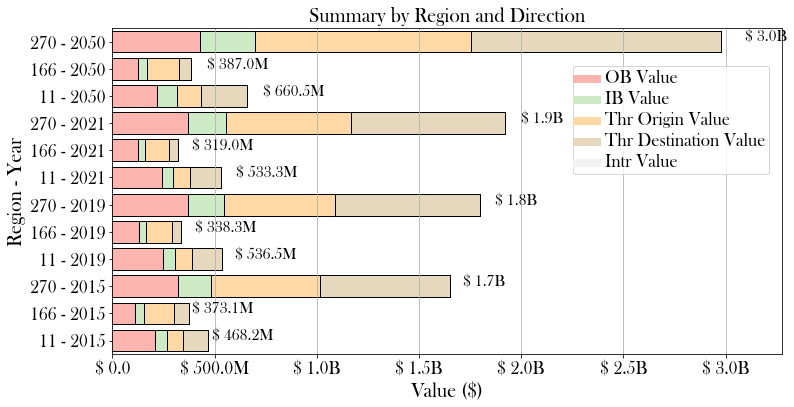

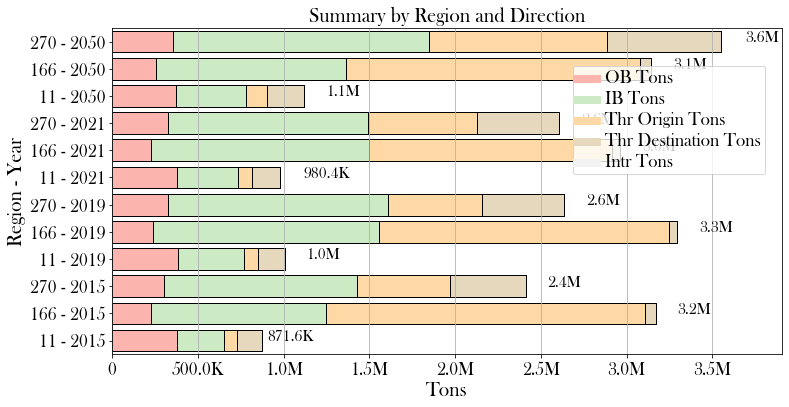

In [72]:
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

font = FontProperties(family='Baskerville Old Face')

def formatter(x, pos, data_type):
    if data_type == 'Value':
        return f'$ {x/1e9:.1f}B' if x >= 1e9 else f'$ {x/1e6:.1f}M' if x >= 1e6 else f'$ {x/1e3:.1f}K' if x >= 1e3 else f'$ {x:.1f}'
    else:
        return f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.1f}K' if x >= 1e3 else f'{x:.0f}'

def plot_summary_by_region_and_direction(df, data_type):
    # Copy the DataFrame to avoid modification warnings
    df_copy = df.copy()

    # Concatenate the Region and Year information
    df_copy['Region_Year'] = df_copy['Region'].astype(str) + ' - ' + df_copy['Year'].astype(str)

    directions = [f'OB {data_type}', f'IB {data_type}', f'Thr Origin {data_type}', f'Thr Destination {data_type}', f'Intr {data_type}']
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(directions)))

    fig, ax = plt.subplots(figsize=(12, len(df_copy) * 0.5))
    ax.set_ylim([-0.5, len(df_copy) - 0.5])

    max_y_value = 0
    bar_index = 0
    for idx, row in df_copy.iterrows():
        left_value = 0
        total_value = 0
        for i, direction in enumerate(directions):
            value = row[direction] if not pd.isnull(row[direction]) else 0
            rects = ax.barh(row['Region_Year'], value, color=colors[i], edgecolor='black', left=left_value, label=direction if idx == 0 else "", alpha=1.0, height=0.8)
            width = rects[0].get_width()
            max_y_value = max(max_y_value, left_value + width)
            left_value += value
            total_value += value

        ax.annotate(formatter(total_value, 0, data_type), xy=(total_value + (max_y_value * 0.04), bar_index), xycoords='data', fontsize=16, color='black', fontproperties=font)
        bar_index += 1

    ax.set_xlim([0, max_y_value * 1.1])

    legend_elements = [plt.Line2D([0], [0], color=colors[i], lw=8, label=direction) for i, direction in enumerate(directions)]
    legend = ax.legend(handles=legend_elements, bbox_to_anchor=(0.68, .9), loc='upper left')

    for text in legend.get_texts():
        text.set_fontproperties(font)
        text.set_fontsize(18)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(font)
        tick.set_fontsize(18)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(font)
        tick.set_fontsize(18)

    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: formatter(x, pos, data_type)))
    ax.xaxis.grid(True, linestyle='-')
    ax.set_title(f'Summary by Region and Direction', fontsize=20, fontproperties=font)
    ax.set_xlabel(data_type + (' ($)' if data_type == 'Value' else ''), fontsize=20, fontproperties=font)
    ax.set_ylabel('Region - Year', fontsize=20, fontproperties=font)
    plt.show()

# Usage
plot_summary_by_region_and_direction(filtered_summary_values, 'Value')
plot_summary_by_region_and_direction(filtered_summary_tons, 'Tons')


In [70]:
filtered_summary_values

,Year,Region,Region Name,OB Value,IB Value,Thr Origin Value,Thr Destination Value,Intr Value,Total Value,Region_Year
10,2015,11,"Mohave County, AZ",2.065561e+08,6.142336e+07,8.016708e+07,1.200437e+08,0.0,4.681902e+08,11 - 2015
165,2015,166,Remainder of Nevada Portion of Las Vegas BEA,1.094366e+08,4.503524e+07,1.478220e+08,7.082190e+07,0.0,3.731157e+08,166 - 2015
269,2015,270,Utah Portion of Las Vegas BEA,3.209468e+08,1.634195e+08,5.320041e+08,6.337466e+08,0.0,1.650117e+09,270 - 2015
384,2019,11,"Mohave County, AZ",2.455968e+08,6.193960e+07,8.001028e+07,1.489377e+08,0.0,5.364843e+08,11 - 2019
539,2019,166,Remainder of Nevada Portion of Las Vegas BEA,1.287706e+08,3.573545e+07,1.292666e+08,4.449806e+07,0.0,3.382707e+08,166 - 2019
643,2019,270,Utah Portion of Las Vegas BEA,3.713804e+08,1.758308e+08,5.411317e+08,7.092582e+08,0.0,1.797601e+09,270 - 2019
758,2021,11,"Mohave County, AZ",2.411302e+08,5.785966e+07,7.979563e+07,1.545015e+08,0.0,5.332870e+08,11 - 2021
913,2021,166,Remainder of Nevada Portion of Las Vegas BEA,1.271259e+08,3.300753e+07,1.154929e+08,4.334572e+07,0.0,3.189721e+08,166 - 2021
1017,2021,270,Utah Portion of Las Vegas BEA,3.684338e+08,1.865673e+08,6.117282e+08,7.562625e+08,0.0,1.922992e+09,270 - 2021
1132,2050,11,"Mohave County, AZ",2.196299e+08,9.624233e+07,1.191302e+08,2.255138e+08,0.0,6.605163e+08,11 - 2050


In [71]:
# Group by Year, Region, and other necessary columns, then sum the directional tons
summary_tons = final_summary_R_commodity.groupby(['Year', 'Region', 'Region Name']).agg({
    'OB Tons': 'sum',
    'IB Tons': 'sum',
    'Thr Origin Tons': 'sum',
    'Thr Destination Tons': 'sum',
    'Intr Tons': 'sum'
}).reset_index()

# Calculate the total tons for each group
summary_tons['Total Tons'] = summary_tons[['OB Tons', 'IB Tons', 'Thr Origin Tons', 'Thr Destination Tons', 'Intr Tons']].sum(axis=1)

# Filter the summary_tons DataFrame to include only the specified regions
filtered_summary_tons = summary_tons[summary_tons['Region'].isin(regions_of_interest)]


In [73]:
# Define the file paths
filtered_summary_tons_path = r'H:\My Drive\7. SNV Industry Study\1.) Summary\Regions\File\filtered_summary_tons.xlsx'
filtered_summary_values_path = r'H:\My Drive\7. SNV Industry Study\1.) Summary\Regions\File\filtered_summary_values.xlsx'


# Save the DataFrames to Excel files
filtered_summary_tons.to_excel(filtered_summary_tons_path, index=False)
filtered_summary_values.to_excel(filtered_summary_values_path, index=False)

FileCreateError: [Errno 13] Permission denied: 'H:\\My Drive\\7. SNV Industry Study\\1.) Summary\\Regions\\File\\filtered_summary_values.xlsx'